# Import Libraries

In [26]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer  # Import SimpleImputer from sklearn.impute

# Set the style for seaborn
sns.set(style='darkgrid')

# Define Directory Path and Data Storage

In [27]:
directory_path = 'Data'  # Replace with your directory path

# Dictionary to hold each company's data
company_data = {}

# Read CSV Files and Store Data

In [28]:
for file in os.listdir(directory_path):
    if file.endswith(".csv"):
        try:
            # Read the CSV into a DataFrame
            df = pd.read_csv(os.path.join(directory_path, file))
            
            # Extract company code from the filename
            company_code = int(file.split(".")[0])
            
            # Store the DataFrame in the dictionary with the company code as the key
            company_data[company_code] = df
        except pd.errors.ParserError:
            print(f"Error parsing {file}. Skipping...")
            continue
        except pd.errors.EmptyDataError:
            print(f"File {file} is empty or has no valid data. Skipping...")

# Data Analysis for a Specific Company

In [29]:
# Choose a specific company code to analyze
company_code_to_analyze = 512301

# Get the DataFrame for the specific company
company_df = company_data.get(company_code_to_analyze)

# Display the first few rows of the DataFrame
print(company_df.head())

# Display the column names to ensure 'Date' is present
print(company_df.columns)

             Date  Open Price  High Price  Low Price  Close Price   WAP  \
0  23-August-2023        4.28        4.28       4.28         4.28  4.28   
1  22-August-2023        4.28        4.28       4.28         4.28  4.28   
2  21-August-2023        4.50        4.50       4.50         4.50  4.50   
3  17-August-2023        4.56        4.56       4.56         4.56  4.56   
4  14-August-2023        4.56        4.56       4.56         4.56  4.56   

   No.of Shares  No. of Trades  Total Turnover (Rs.)  Deliverable Quantity  \
0          1000              4                4280.0                1000.0   
1          1000              2                4280.0                1000.0   
2             4              1                  18.0                   4.0   
3          1000              2                4560.0                1000.0   
4          1050              5                4788.0                1050.0   

   % Deli. Qty to Traded Qty  Spread High-Low  Spread Close-Open  
0            

# Convert Date Column to Datetime

In [30]:
# Check if 'Date' column exists before converting
if 'Date' in company_df.columns:
    # Convert 'Date' column to datetime
    company_df['Date'] = pd.to_datetime(company_df['Date'], format='%d-%B-%Y')
    # Set 'Date' as the index
    company_df.set_index('Date', inplace=True)
else:
    print("Error: 'Date' column not found in the DataFrame")


# Feature Engineering

In [31]:
# Create additional features
company_df['Year'] = company_df.index.year
company_df['Month'] = company_df.index.month
company_df['Day'] = company_df.index.day

# Define Features and Target

In [32]:
# Define the features (X) and the target (y)
features = ['Open Price', 'High Price', 'Low Price', 'No.of Shares', 'No. of Trades', 'Total Turnover (Rs.)', 'Deliverable Quantity', 'Year', 'Month', 'Day']
target = 'Close Price'

X = company_df[features]
y = company_df[target]

# Handling Missing Values

In [33]:
# Use SimpleImputer to fill missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Train-Test Split

In [34]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Data Scaling

In [35]:
# Standardize the features using a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

# Model Training

In [36]:
# Train a Linear Regression model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', LinearRegression())])

# Model Evaluation

In [38]:
# Predict on the test set
y_pred = pipeline.predict(X_test)

# Calculate the mean squared error and R-squared value
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-Squared Value: {r2}")

Mean Squared Error: 0.05465233618077998
R-Squared Value: 0.9976663384059603


# Plot Predictions vs Actual

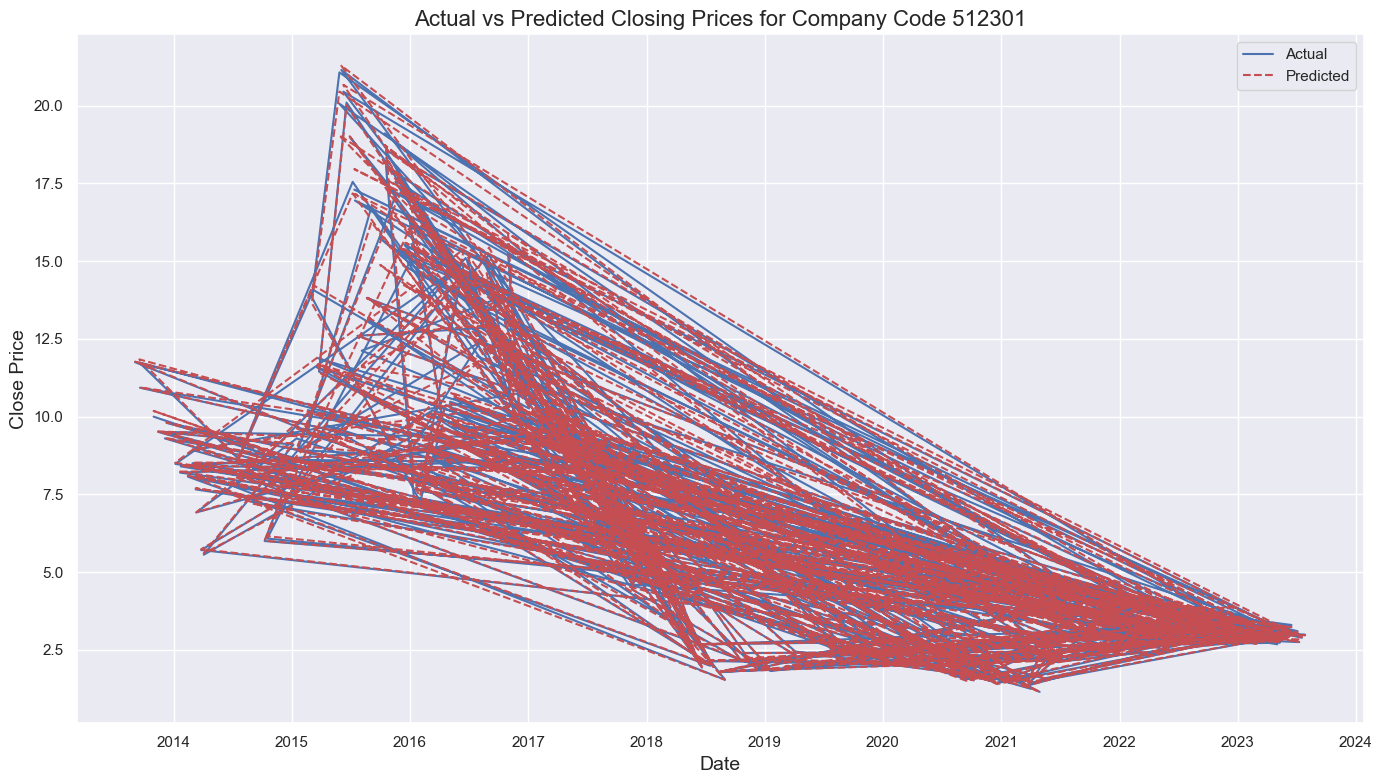

In [39]:
plt.figure(figsize=(14, 8))
plt.plot(y_test.index, y_test, label='Actual', color='b')
plt.plot(y_test.index, y_pred, label='Predicted', color='r', linestyle='--')
plt.title(f'Actual vs Predicted Closing Prices for Company Code {company_code_to_analyze}', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Learning Curve

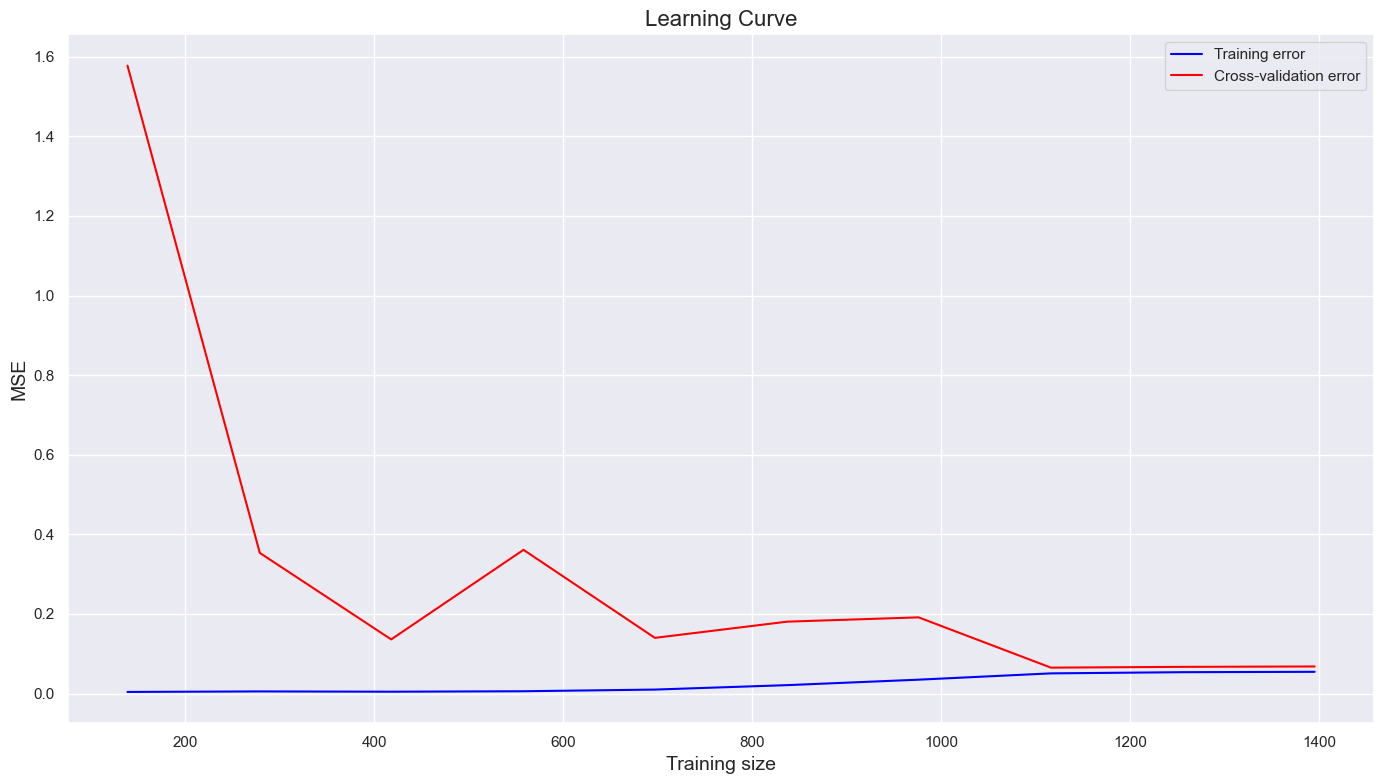

In [40]:
# Plot the learning curve
train_sizes, train_scores, test_scores = learning_curve(pipeline, X_imputed, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = -train_scores.mean(axis=1)
test_scores_mean = -test_scores.mean(axis=1)

plt.figure(figsize=(14, 8))
plt.plot(train_sizes, train_scores_mean, label='Training error', color='blue')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation error', color='red')
plt.title('Learning Curve', fontsize=16)
plt.xlabel('Training size', fontsize=14)
plt.ylabel('MSE', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Save the Model

In [41]:
import joblib

# Save the trained model
model_filename = f'model_{company_code_to_analyze}.joblib'
joblib.dump(pipeline, model_filename)
print(f"Trained model saved to {model_filename}")

Trained model saved to model_512301.joblib


# Load and Predict with the Saved Model (Optional)

In [42]:
# Load the saved model
loaded_model = joblib.load(model_filename)

# Predict with the loaded model
y_loaded_pred = loaded_model.predict(X_test)

# Verify that the loaded model gives the same predictions
np.allclose(y_pred, y_loaded_pred)

True